In [1]:
import os

import cv2
import seaborn as sns
import toml

from modules.plot import plot_image_table, get_img_tiles_by_row_vals
from modules.utils import load
from modules.utils import order
from tasks.experiment import Cleansing
from tasks.totaling import EvalCleansing, TotalizeCleansingWrtEval

sns.set()
sns.set_style('ticks')

TensorFlow version 1.15.3 has been patched using tfdeterminism version 0.3.0


In [2]:
out_dir = 'results/'
os.makedirs(out_dir, exist_ok=True)


In [3]:
# plot settings
d_metric_printedname = dict((
        ('loss_d', 'Influence on Disc. Loss'),
        ('if_data', 'Isolation Forest'),
        ('random', 'Random'),
        ('inception_score', 'Influence on IS (Ours)'),
        ('fid', 'Influence on FID (Ours)'),
        ('if', 'Isolation Forest'),
    ))

ext_savefig = 'png'
kwargs_savefig = {'dpi': 300}

path_conf = 'conf/mnist_cleansing.toml'

idx_removal_rate = 7 # 25k

first_nseeds = 5
nlevels_contour = 8

In [4]:
# load configs and identify processed dirs
# these results can be loaded only after finishing the experiment command written in "Experiment 2: Data Cleansing" of README.md

conf = toml.load(open(path_conf, 'r'))[TotalizeCleansingWrtEval.__name__]

conf_popped = {
    'seeds': conf.pop('seeds'),
    'removal_rates': conf.pop('removal_rates'),
    'metrics': conf.pop('metrics'),
    'eval_metrics': conf.pop('eval_metrics')
}

# get intermediate files of instance scoring before the cleansing by changing selection metric
d_metric_clean_dir = {
    metric: Cleansing(
        **conf,
        seed=conf_popped['seeds'][0],
        metric=metric,
        removal_rate=conf_popped['removal_rates'][idx_removal_rate]
    ).output().path for metric in conf_popped['metrics']
}

# get intermediate files of test GAN evaluation metrics after the cleansing by changing selection metric
d_metric_eval_dir = {
    metric: EvalCleansing(
        **conf,
        seed=conf_popped['seeds'][0],
        metric=metric,
        eval_metric=conf_popped['eval_metrics'][0],
        removal_rate=conf_popped['removal_rates'][idx_removal_rate]
    ).output().path for metric in conf_popped['metrics']
}


seeds = conf_popped['seeds'][:first_nseeds]

d_seed_clean_dir = {
    seed: Cleansing(
        **conf,
        seed=seed,
        metric=conf_popped['metrics'][0],
        removal_rate=conf_popped['removal_rates'][idx_removal_rate]
    ).output().path for seed in seeds
}

d_seed_eval_dir = {
    seed: EvalCleansing(
        **conf,
        seed=seed,
        metric=conf_popped['metrics'][0],
        eval_metric=conf_popped['eval_metrics'][0],
        removal_rate=conf_popped['removal_rates'][idx_removal_rate]
    ).output().path for seed in seeds
}


names_result = [
    'help_x',
    'harm_x',
    'original',
    'cleansed',
]

d_name_filename = {
    'help_x': 'help_x.pkl',
    'harm_x': 'harm_x.pkl',
    'original': 'original.pkl',
    'cleansed': 'cleansed.pkl',
}

d_name_printedname = {
    'harm_x': 'Harmful training instances',
    'help_x': 'Helpful training instances',
    'original': 'Generated samples (original)',
    'cleansed': 'Cleansed samples (cleansed)'
}


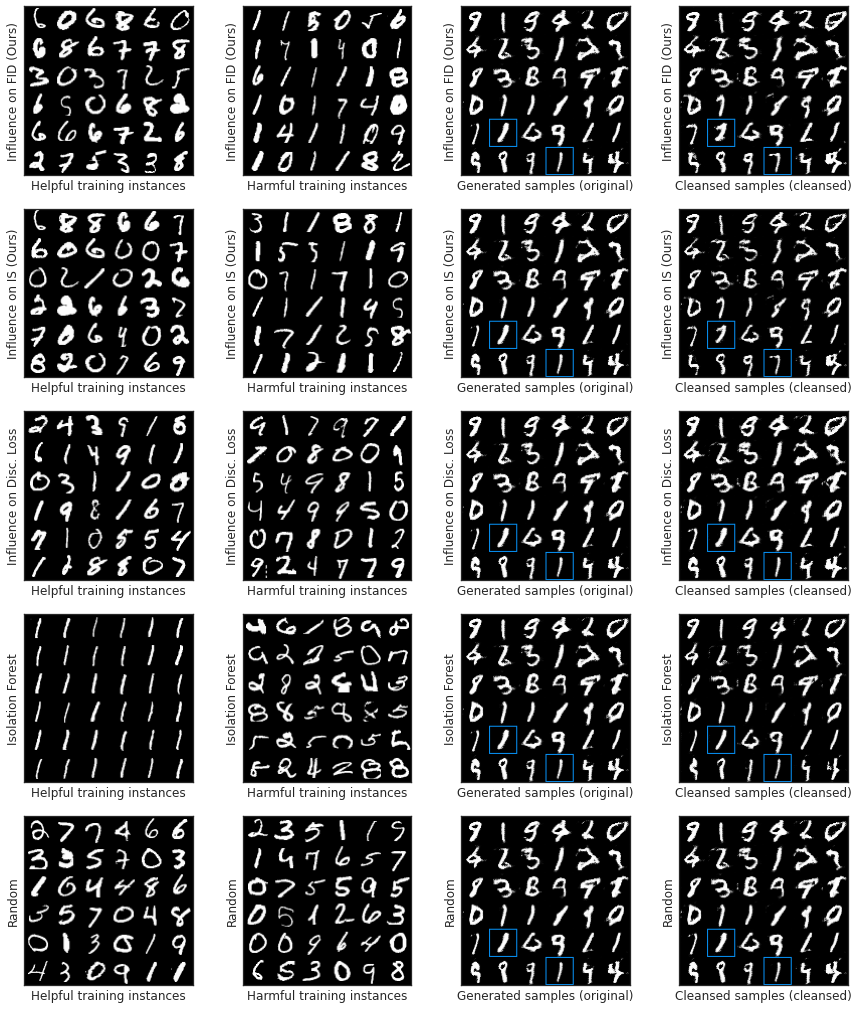

In [5]:
# instance (harmful, helpful, no removal, cleansed) visualization with respect to selection method
def callback_replace_xs(row_val, name, xs): # highlight some instances for qualitative study in the paper
    if name in ['original', 'cleansed']:
        for idx in [25, 33]:
            cv2.rectangle(xs[idx], (0, 0), (27, 27), (7, 148, 250))
    return xs


def get_path(row_val, name):
    if name in ['help_x', 'harm_x']:
        dirname = d_metric_clean_dir[row_val]
    elif name in ['original', 'cleansed']:
        dirname = d_metric_eval_dir[row_val]
    else:
        raise ValueError(name)
    filename = d_name_filename[name]
    return os.path.join(dirname, filename)

row_vals = conf_popped['metrics']

# collect helpful harmful no-removal (original) cleansed mnist images to make tile image of them
x_tiles_by_metrics = get_img_tiles_by_row_vals(row_vals, names_result, get_path, callback_replace_xs)

plot_image_table(x_tiles_by_metrics, 
                 [d_metric_printedname[x] for x in row_vals], 
                 [d_name_printedname[x] for x in names_result],
                (15, 18))


In [6]:
# print latex sourcre commands
for metric in conf_popped['metrics']:
    result = load(os.path.join(d_metric_eval_dir[metric], f'result.pkl'))
    fid_ori = result["metric_no_removal"]
    fid_cl = result["metric_cleansed"]
    print(f'{{{metric}}}{{{d_metric_printedname[metric]}}}{{{fid_cl - fid_ori:+.2f}}}')

{fid}{Influence on FID (Ours)}{-0.85}
{inception_score}{Influence on IS (Ours)}{-0.71}
{loss_d}{Influence on Disc. Loss}{-0.21}
{if}{Isolation Forest}{+1.80}
{random}{Random}{-0.21}


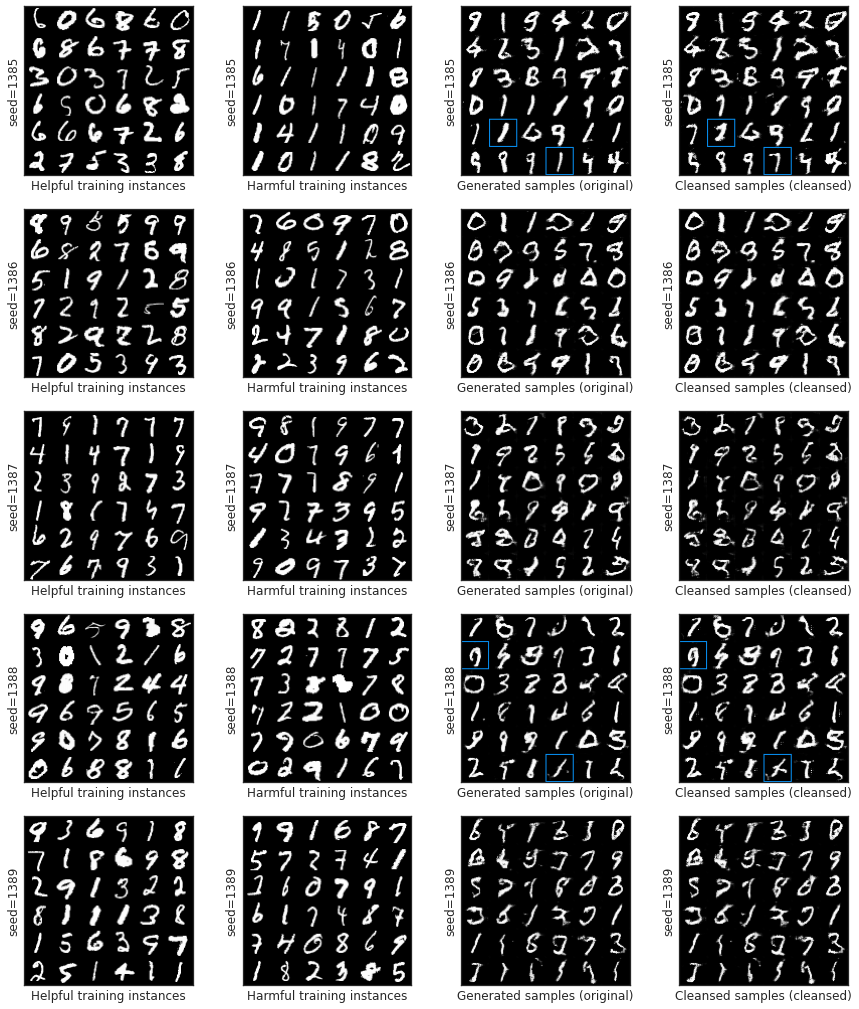

In [7]:
# instance (harmful, helpful, no removal, cleansed) visualization with respect to random seed
def callback_replace_xs(row_val, name, xs): # highlight some instances for qualitative study in the paper
    if name in ['original', 'cleansed']:
        if row_val in [1385, 1388]:
            if row_val == 1385:
                idxs = [25, 33]
            else:
                idxs = [6, 33]
            for idx in idxs:
                cv2.rectangle(xs[idx], (0, 0), (27, 27), (7, 148, 250))

    return xs

def get_path(row_val, name):
    if name in ['help_x', 'harm_x']:
        dirname = d_seed_clean_dir[row_val]
    elif name in ['original', 'cleansed']:
        dirname = d_seed_eval_dir[row_val]
    else:
        raise ValueError(name)
    filename = d_name_filename[name]
    return os.path.join(dirname, filename)

row_vals = seeds
x_tiles_by_metrics = get_img_tiles_by_row_vals(row_vals, names_result, get_path, callback_replace_xs)
plot_image_table(x_tiles_by_metrics, [f'seed={x}' for x in row_vals], [d_name_printedname[x] for x in names_result], (15, 18))

In [8]:
# print latex source commands

for i, seed in enumerate(seeds):
    result = load(os.path.join(d_seed_eval_dir[seed], f'result.pkl'))
    fid_ori = result["metric_no_removal"]
    fid_cl = result["metric_cleansed"]
    print(f'{{{seed}}}{{{order(i+1)} random seed.}}{{{fid_cl-fid_ori:+.2f}}}')

{1385}{1st random seed.}{-0.85}
{1386}{2nd random seed.}{-0.45}
{1387}{3rd random seed.}{+0.09}
{1388}{4th random seed.}{-0.71}
{1389}{5th random seed.}{-0.12}
